# TMA4215 - Assignment 3 - Linear Multistep Methods

**Deadline:** Wednesday September 30, 11:59PM

**Problem 1.** Predictor corrector method. Implementation.
You shall write a function that implements a Predictor-Corrector scheme as described below. You shall demonstrate that it works on a specified test problem.

We consider a pair of two-step methods, the predictor [P] is the two-step Adams-Bashforth method, the corrector is the two-step Adams-Moulton method. They read as follows

\begin{align*}
[\text{Adams-Bashforth}]\quad & u_{n+2} - u_{n+1} = h\,\left(\frac32 f_{n+1} - \frac12 f_n\right) \\
[\text{Adams-Moulton}]\quad & u_{n+2} - u_{n+1} = h\, \left(\frac{5}{12}f_{n+2}+\frac23 f_{n+1}-\frac{1}{12} f_n\right)
\end{align*}

With reference to the lectures and section 11.7 in the book (see in particular Example 11.8 on page 514) you shall implement the method as in *PECE* mode with constant step size. You need a starting method for the first step. For this you will use the second order explicit two-stage Runge-Kutta method known as improved Euler (other names are Heun's method or explicit trapeziodal method).

$$
\begin{array}{c|rr}
0 & 0 \\
1 & 1 \\ \hline
  & \frac12 & \frac12
\end{array}
$$

So the computation sequence is
1. Take one step with the improved Euler method and step size $h$
2. Do time stepping with the Predictor-Corrector method until the largest $n$ such that $t_n=t_0+nh<T$.
3. If $t_n<T$, Take one final step with the improved Euler method, using the stepsize $h_f = T-t_n$.


**(a)** Write a Python function *ABM2* as indicated in the template below. Its input parameters are
* f   A function f(t,y) that defines the differental equation
* y0  The intial value (vector)
* t0  The initial time
* T   The final time
* h   The (constant) stepsize

**(b)** Test it out on the Lotka-Volterra Volterra problem

\begin{align*}
\dot{u} &= u(v-2) & u(0)&=2\\
\dot{v} &= v(1-u) & v(0)&=1
\end{align*}

First write the function *LV(t,y)*. Generate a phase plot, where you use $h=0.08$. This means to plot *y[1]* vs
*y[0]* that is, *v* vs *u* in the Lotka-Volterra system above. You should get a closed loop (a periodic solution). Make $T$ just big enough to complete one period.

**Control question 1.** Using ABM2(LV,y0,t0,T,h) where $y_0=[2,1]^T$, $t_0=0$, $T=2$, $h=0.03$, what is the resulting approximation to $u(2)$?

**(c)** You will now learn a very standard method for estimating the convergence order of the method. This is actually a great code verification tool when you are writing software for solving ODEs. We explain it in steps.

1. Let $T$ be the final time in which you want to test (the order of) the method on a given problem.
2. Compute a reference solution at $t=T$, i.e. an approximation *yexact* of high accuracy to the solution at $t=T$. This can be done in different ways. One is to make a call to a builtin function with strict tolerances, e.g. *scipy.integrate* seems to contain several solvers. Another option is to write a simple solver with good accuracy, you could do for instance the standard four stage fourth order Runge-Kutta method. To save you some work, we offer a simple implementation of this method below (RK4) that you can use if you prefer. The important thing with the reference solution is that it is accurate enough to estimate the smallest error in your test.
3. Now, take a suitable range of log-spaced stepsizes. For our problem here, a first attempt could be to set
*HH=numpy.logspace(-4,-1,20)* that gives you a numpy-array of 20 stepsizes log-spaced between $10^{-4}$ and $10^{-1}$.
4. Run the method/implementation you want to test for all these stepsizes up to time $t=T$. For each stepsize $h$ in *HH* , compute  $\|y_T(h)-y_{ex}\|$ where $y_T(h)$ is your approximation at $t=T$ for this stepsize, and $y_{ex}$ is the reference solution *yexact*. Store these values in a numpy-array *err.
5. Now make a loglog-plot of *err* vs *HH*. If the error behaves like $C h^p$ this should give a straight line of slope $p$ in the loglog-plot.
6. Estimate the order as numbers. Since our hypothesis is that for a stepsize $h_i$, the corresponding error is of the form $\mathrm{err}_i \approx Ch_i^{p}$, we can estimate $p$ from two stepsizes $h_1$ and $h_2$.
$$
\mathrm{err}_i \approx Ch_i^{p},\ i=1,2\quad\Rightarrow\quad p \approx \frac{\log\frac{\mathrm{err}_1}{\mathrm{err}_2}}{\log\frac{h_1}{h_2}}
$$
You can compute this expression for every consecutive pair of stepsizes $(h_i, h_{i+1})$.

In your Jupyter Notebook, please implement this order test for the Lotka-Volterra problem to estimate the order of the ABM2 method. In the test, use the LV-function from **(b)**, set $y_0=[2,1]^T$, $t_0=0$, $T=10$ and use stepsizes logspaced in the range $10^{-4},\ldots,10^{-1}$.

**Control question 2.** What seems to be the observed order of the ABM2 implementation described above.


In [1]:
import numpy as np

def ABM2(f,y0,ts,T,h):
    '''This version only stores final value'''
    
    t0 = ts
    t1 = t0+h
    K1 = f(t0,y0)
    K2 = f(t1,y0+h*K1)
    y1 = y0+ h/2*(K1+K2)
    
    f0 = K1
    f1 = f(t1,y1)
    
    N = int((T-t0)/h)
    
    for n in range(1,N):
        t2=t1+h
        y2 = y1 + h*(1.5*f1-0.5*f0)
        f2 = f(t2,y2)
        y2 = y1 + h*(5/12*f2+2/3*f1-1/12*f0)
        f2 = f(t2,y2)
        t0,t1=t1,t2
        y1 = y2
        f0,f1=f1,f2
    
    if t1 < T:
        hf = T-t2
        K1=f2
        K2 = f(t2+hf,y2+hf*K1)
        y2 = y1+hf/2*(K1+K2)
    
    return T,y2

def LV(t,y):
    yd = np.array([y[0]*(y[1]-2), y[1]*(1-y[0])])
    return yd
        

def ABM2s(f,y0,t0,T,h):
# stores the solution values throughout the integration interval
    N = int((T-t0)/h)
    finstep = 0
    if t0+N*h < T:
        finstep = 1
    TT = h*np.arange(N+1+finstep)
    TT[-1] = T
    
    m = len(y0)
    YY = np.zeros( (m,N+1+finstep))
    YY[:,0] = y0
# take the first step (get starting value) by explicit trapezoid method
    K1 = f(TT[0],YY[:,0])
    K2 = f(TT[1],YY[:,0]+h*K1)
    YY[:,1] = YY[:,0] + h/2*(K1+K2)
# Prepare to start multistep method
    f0 = K1
    f1 = f(TT[1],YY[:,1])
    for n in range(1,N):
        YY[:,n+1] = YY[:,n]+h*(1.5*f1-0.5*f0)    # Predictor (P)
        f2 = f(TT[n+1],YY[:,n+1])              # Evaluate (E)
        YY[:,n+1] = YY[:,n] + h*(5/12*f2+2/3*f1-1/12*f0)  # Corrector (C)
        f2 = f(TT[n+1],YY[:,n+1])              # Evaluate (E)
        f0, f1 = f1, f2
    if finstep==1:
        hf = TT[-1]-TT[-2]
        K1=f2
        K2 = f(TT[-1],YY[:,-2]+hf*K1)
        YY[:,-1] = YY[:,-2]+hf/2*(K1+K2)
    return TT, YY
    

In [3]:
def RK4(f,y0,t0,T,h):
    ''' This version stores only the final value'''
    N=int((T-t0)/h)
    t=t0
    y=y0
    
    for n in range(N):
        K1 = f(t,y)
        K2 = f(t+h/2,y+h/2*K1)
        K3 = f(t+h/2,y+h/2*K2)
        K4 = f(t+h,y+h*K3)
        y  = y + h/6*(K1+2*K2+2*K3+K4)
        t  = t+h
    if t < T:
        hf = T-t
        K1 = f(t,y)
        K2 = f(t+hf/2,y+hf/2*K1)
        K3 = f(t+hf/2,y+hf/2*K2)
        K4 = f(t+hf,y+hf*K3)
        y  = y + hf/6*(K1+2*K2+2*K3+K4)
    return T, y


def RK4s(f,y0,t0,T,h):
    '''This version stores the solution over the whole integration interval'''
    N=int((T-t0)/h)
    finstep=0
    if t0+N*h < T:
        finstep=1
    TT = h*np.arange(N+1+finstep)
    TT[-1] = T
    
    m = len(y0)
    YY = np.zeros( (m,N+1+finstep))
    YY[:,0] = y0
    
    for n in range(N):
        K1 = f(TT[n],YY[:,n])
        K2 = f(TT[n]+h/2,YY[:,n]+h/2*K1)
        K3 = f(TT[n]+h/2,YY[:,n]+h/2*K2)
        K4 = f(TT[n+1],YY[:,n]+h*K3)
        YY[:,n+1] = YY[:,n] + h/6*(K1+2*K2+2*K3+K4)
        
    if finstep==1:
        hf = TT[N+1]-TT[N]
        K1 = f(TT[N],YY[:,N])
        K2 = f(TT[N]+hf/2,YY[:,N]+hf/2*K1)
        K3 = f(TT[N]+hf/2,YY[:,N]+hf/2*K2)
        K4 = f(TT[N+1],YY[:,N]+hf*K3)
        YY[:,-1] = YY[:,N] + hf/6*(K1+2*K2+2*K3+K4)
    return TT, YY


Answer to 1b)


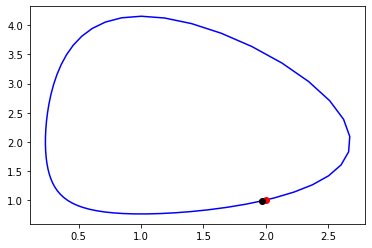

Answer to Control question 1
u(2)= 0.25216918676031025


 Answer to 1c)

Calculating exact solution ...
yex [1.13205553 0.76619489]
HH [0.0001     0.00014384 0.00020691 0.00029764 0.00042813 0.00061585
 0.00088587 0.00127427 0.00183298 0.00263665 0.00379269 0.00545559
 0.0078476  0.01128838 0.01623777 0.02335721 0.03359818 0.0483293
 0.06951928 0.1       ]
err [7.33325868e-12 2.38855004e-11 5.40696666e-11 6.33013611e-11
 2.10182769e-10 6.77130331e-10 2.04655685e-09 6.14826391e-09
 1.83648930e-08 5.46761117e-08 1.63677928e-07 4.84052287e-07
 1.43915447e-06 4.29109314e-06 1.27634212e-05 3.79237131e-05
 1.13525492e-04 3.42911015e-04 1.06144998e-03 3.38804283e-03]


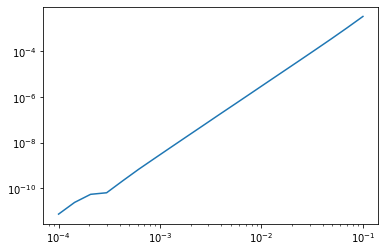

order estimates: [3.24796981 2.2471892  0.43357592 3.30083239 3.21780933 3.04222646
 3.02561502 3.00982737 3.00079173 3.01588582 2.98238033 2.99702918
 3.0049167  2.99819469 2.99531041 3.01582275 3.04055761 3.10788129
 3.19231259]



Answer to Control question 2
Average order is: 3


In [4]:
import matplotlib.pyplot as plt

# Answer to 1b)
print("Answer to 1b)")
y0=np.array([2,1])
t0=0
T=4.85
h=0.08

TT, YY = ABM2s(LV,y0,t0,T,h)

plt.plot(YY[0,:],YY[1,:],'b')
plt.plot(YY[0,0],YY[1,0],'ro')
plt.plot(YY[0,-1],YY[1,-1],'ko')

plt.show()


# Answer to Control question 1

print("Answer to Control question 1")
y0=np.array([2,1])
t0=0
T=2
h=0.03

[TT,YY]= ABM2s(LV,y0,t0,T,h) 
print("u(2)=",YY[0,-1])



# 1c)  order test 

print("\n\n Answer to 1c)\n")
y0=np.array([2,1])
t0=0
T=15

nexps=20
loglow=-4
loghigh=-1
HH=np.logspace(-4,-1,nexps)
err = np.zeros((nexps,))
print("Calculating exact solution ...")
tex,yex = RK4(LV,y0,t0,T,HH[0]/2)
for nex in range(nexps):
 #   print("Experiment no",nex)
    tf,yf=ABM2(LV,y0,t0,T,HH[nex])
    err[nex] = np.linalg.norm(yex-yf)

print("yex",yex)
print("HH",HH)
print("err",err)
plt.loglog(HH,err)
plt.show()

order = np.log(err[1:]/err[:-1])/np.log(HH[1:]/HH[:-1])
print("order estimates:",order)

print("\n\n\nAnswer to Control question 2")
ordav = np.round(np.average(order))
print("Average order is:",int(ordav))



**Problem 2.** Determine which (if any) of the following linear multistep methods are convergent. If convergent, determine also the order of the method. Include your argument and some calculations as you see fit.

**(a)**

$$
u_{n+3}+u_{n+2} - u_{n+1} - u_{n} = \frac{h}{3}(f_{n+3}+5f_{n+2}+5f_{n+1}+f_n)
$$

**(b)**

$$
u_{n+3}-u_{n+2} + u_{n+1} - u_{n} =  \frac{h}{6}(11 f_{n+2}-4 f_{n+1}+5f_n)
$$


**Control question 3.** Is the method in **(2a)** convergent? 

**Answer:** No (the reason being that the polynomial $\rho(z)$ has a double root at $z=-1$)


**Control question 4.** Is the method in **(2b)** convergent? 

**Answer:** Yes. Here the polynomial $\rho(z)$ factors as $(z-1)(z^2+1)$ so roots at $1$ and $\pm i$. It is of order 3 which can for instance be checked by expanding 

$$\rho(e^h)-h\sigma(e^h),\quad \rho(z)=z^3-z^2+z-1,\quad \sigma(z)=\frac16 (11z^2-4z+5)$$

in a taylor series about $h=0$ (use e.g. Maple).